# 프로젝트: 자율 주행 보조 시스템 만들기
---
|평가문항|상세기준|
|:---|:---|
|1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|
|2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|
|3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다.|

---
## KITTI 데이터셋
자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공

|Values|Name|Description|
|:---|:---|:---|
|1|type|Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc' or 'DontCare'|
|1|truncated|Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries|
|1|occluded|Integer (0,1,2,3) indicating occlusion state: 0 = fully visible, 1 = partly occluded 2 = largely occluded, 3 = unknown|
|1|alpha|Observation angle of object, ranging \[-pi..pi\]|
|4|bbox|2D bounding box of object in the image (0-based index): contains left, top, right, bottom pixel coordinates|
|3|dimensions|3D object dimensions: height, width, length (in meters)|
|3|location|3D object location x,y,z in camera coordinates (in meters)|
|1|rotation_y|Rotation ry around Y-axis in camera coordinates \[-pi..pi\]|
|1|score|Only for results: Float, indicating confidence in detection, needed for p/r curves, higher is better.|

In [2]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

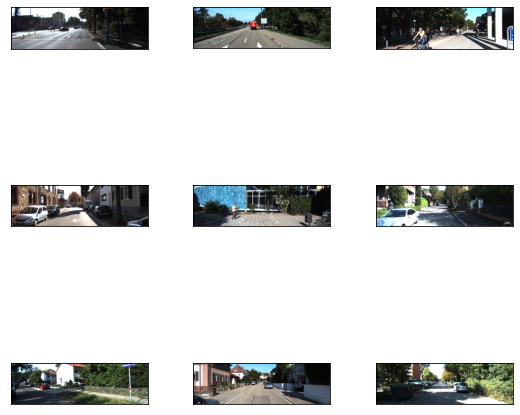

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.75,  2.39,  2.54, -1.21, -1.26,  2.14,  2.72,  1.76],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[0.31176   , 0.5591465 , 0.53098667, 0.6518679 ],
       [0.22274667, 0.8595089 , 0.59493333, 0.99919486],
       [0.33      , 0.7747021 , 0.6758133 , 0.99919486],
       [0.29101333, 0.22861513, 0.42504   , 0.30971014],
       [0.33984   , 0.2735024 , 0.51432   , 0.35524958],
       [0.04029333, 0.        , 0.44781333, 0.21161836],
       [0.41181332, 0.6830676 , 0.60138667, 0.8504187 ],
       [0.41813335, 0.35814816, 0.5188533 , 0.4028261 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[1.55, 1.66, 4.15],
       [1.47, 1.7 , 4.65],
       [1.91, 1.81, 4.33],
       [0.91, 1.32, 2.41],
       [1.63, 1.61, 3.81],
       [1.43, 1.57, 3.48],
       [1.63, 1.67, 4.3

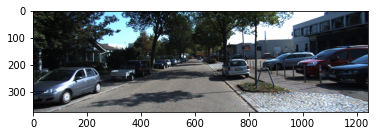

In [3]:
tfds.show_examples(ds_train, ds_info)
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

### 바운딩 박스 그리기

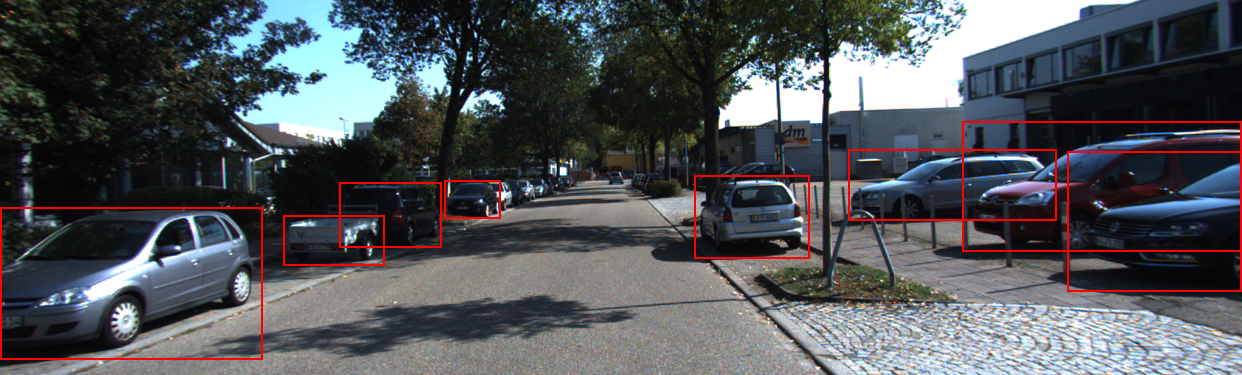

In [4]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 데이터 파이프라인 :  총 4단계
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [5]:
# x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

# 데이터 준비 함수
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## AnchorBox
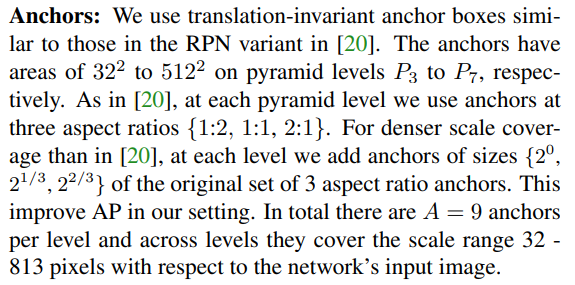  

In [6]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

### IoU 계산 함수

In [7]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

### 실제 라벨을 Anchor Box에 맞춰주는 클래스
compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정 

In [8]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

---
## 모델 작성
---
RetinaNet에서는 FPN(Feature Pyramid Network)를 약간 수정해서 사용  
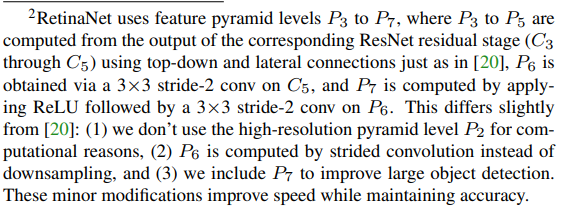  

In [9]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요(head)  
Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class와 box도 예상한다

class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있다
class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요 

그래서 각각의 head를 만들어 줍니다.

In [10]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

### RetinaNet 모델 정의

In [11]:
class RetinaNet(tf.keras.Model):
    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)
    
# RetinaNet backbone - ResNet50
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    # FPN에 이용할 수 있도록 중간 레이어도 output으로 연결
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

---
## 모델 학습
---
### Loss
RetinaNet에서는   
Classification Loss를 계산에는 Focal Loss를 사용 - alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라진다  
Box Regression에는 Smooth L1 Loss를 사용 - delta를 기준으로 계산이 달라진다   

In [12]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

### 모델 컴파일

In [13]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

# learning rate : 논문에서는 8개 GPU 사용 >>> 환경에 맞게 적절히 조정
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

# Optimizer - SGD를 사용
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

94781440/94765736 [==============================] - 0s 0us/step


### 데이터 전처리를 위한 파이프라인 생성

In [14]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

### 모델 학습

In [16]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('./', "retina_weights_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 5

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/5
3173/3173 [==============================] - 1588s 496ms/step - loss: 2.3932 - val_loss: 1.6669

Epoch 00001: saving model to ./retina_weights_epoch_1
Epoch 2/5
3173/3173 [==============================] - 1571s 495ms/step - loss: 1.0213 - val_loss: 1.2864

Epoch 00002: saving model to ./retina_weights_epoch_2
Epoch 3/5
3173/3173 [==============================] - 1572s 495ms/step - loss: 0.7473 - val_loss: 1.1694

Epoch 00003: saving model to ./retina_weights_epoch_3
Epoch 4/5
3173/3173 [==============================] - 1573s 496ms/step - loss: 0.6006 - val_loss: 1.0527

Epoch 00004: saving model to ./retina_weights_epoch_4
Epoch 5/5
3173/3173 [==============================] - 1574s 496ms/step - loss: 0.4934 - val_loss: 1.0857

Epoch 00005: saving model to ./retina_weights_epoch_5


---
## 결과 확인
---

In [15]:
latest_checkpoint = tf.train.latest_checkpoint('./')
model.load_weights(latest_checkpoint)

### 예측 값 디코드 

In [16]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [17]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)


In [18]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


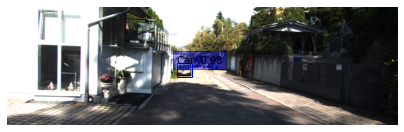

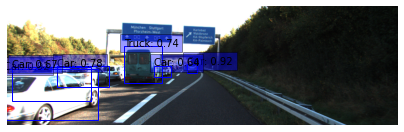

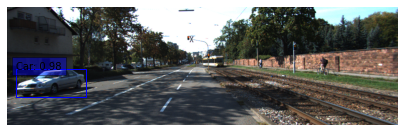

In [19]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(3):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

---
## 자율 주행 시스템 만들기
---
입력으로 이미지 경로를 받습니다.  
정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.  
조건은 다음과 같습니다.  
- 사람이 한 명 이상 있는 경우
- 차량의 크기(width or height)가 300px이상인 경우

image size (1242, 375)


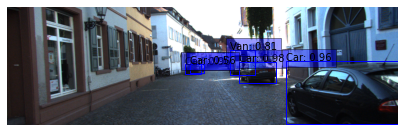

Car 119.39697 67.75896
Car 51.97223 31.559586
Car 354.8595 199.24368
Stop


In [65]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_5.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"  
    image = Image.open(img_path)
    print('image size', image.size)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    visualize_detections(
        image,
        boxes,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )  
    if 'Pedestrian' in class_names:
        print('Pedestrian')
        return 'Stop'
    elif 'Car' in class_names:
        for box, _cls in zip(boxes, class_names):
            if 'Car' == _cls:
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                print('Car', w.numpy(), h.numpy())
                if w.numpy() >= size_limit or h.numpy() >= size_limit:                    
                    return 'Stop'
    return 'Go'

print(self_drive_assist(img_path))

### 자율주행 시스템 평가하기

image size (1224, 370)


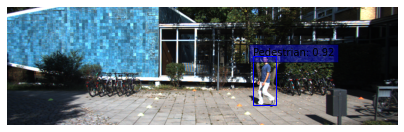

Pedestrian
Stop
image size (1224, 370)


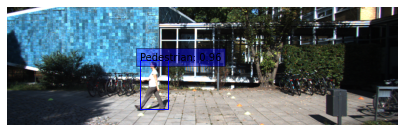

Pedestrian
Stop
image size (1224, 370)


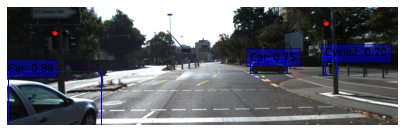

Car 291.39655 167.18433
Car 115.87085 40.666794
Go
image size (1242, 375)


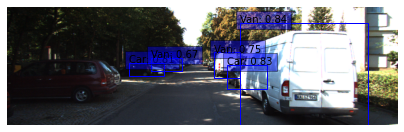

Car 127.13489 75.65992
Car 111.50275 41.44525
Go
image size (1242, 375)


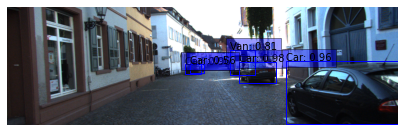

Car 119.39697 67.75896
Car 51.97223 31.559586
Car 354.8595 199.24368
Stop
image size (1242, 375)


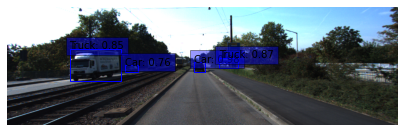

Car 33.394165 29.94577
Car 40.946625 21.793228
Go
image size (1242, 375)


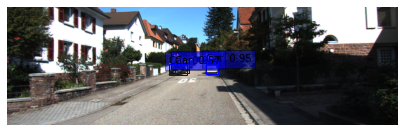

Car 56.039734 34.870697
Car 38.970947 39.977707
Car 44.33136 29.564941
Go
image size (1224, 370)


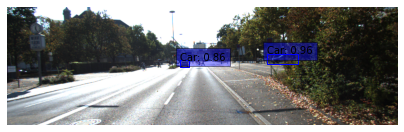

Car 96.83063 30.929031
Car 28.970337 21.701385
Go
image size (1242, 375)


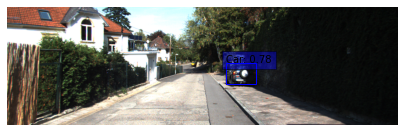

Car 93.84515 69.15617
Go
image size (1242, 375)


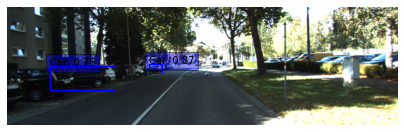

Car 40.253387 28.968735
Car 205.89822 76.82639
Go
80점입니다.


In [66]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(pred)
        if pred == answer:
            score += 10
    print("=========================")        
    print(f"{score}점입니다.")

test_system(self_drive_assist)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('./', "retina_weights2_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 5

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/5
 717/3173 [=====>........................] - ETA: 20:55 - loss: 0.4518